# Viewing 3D volumetric data with matplotlib

Most of you are familiar with image data, taken with ordinary cameras (these are often called "natural images" in the scientific literature), but also with specialized instruments, such as microscopes or telescopes. When working with images in Python, the most common way to display them is using the imshow function of Matplotlib, Python's most popular plotting library.

In this tutorial, we'll show you how to extend this function to display 3D volumetric data, which you can think of as a stack of images. Together, they describe a 3D structure. For example, magnetic resonance imaging (MRI) and computed tomography (CT) scans measure the 3D structure inside the human body; X-ray microtomography measures the 3D structure inside materials such as glass, or metal alloys; and light-sheet microscopes measure fluorescent particles inside biological tissues. 

We'll demonstrate how to download an MRI dataset and display the slices using `matplotlib`. But first, let's go over some basics: how to display images with Matplotlib's `imshow`:

We'll start by enabling the interactive matplotlib mode in the notebook:

In [83]:
%matplotlib notebook

Now, we can import matplotlib and display some image data:

In [84]:
from skimage import data
import matplotlib.pyplot as plt

Now we can import `matplotlib` and display some data. We'll load some example data that is included in the data module of the scikit-image library:

In [85]:
astronaut = data.astronaut()
ihc = data.immunohistochemistry()
hubble = data.hubble_deep_field()

<IPython.core.display.Javascript object>


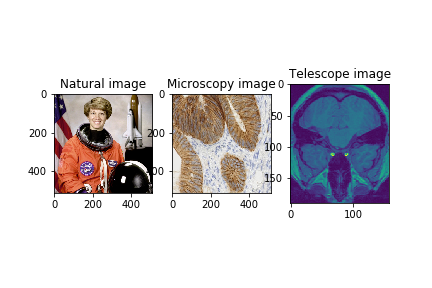

In [86]:
# Initialize the subplot panels side by side
fig, ax = plt.subplots(nrows=1, ncols=3)

# Show an image in each subplot
ax[0].imshow(astronaut)
ax[0].set_title('Natural image')
ax[1].imshow(ihc)
ax[1].set_title('Microscopy image')
ax[2].imshow(hubble)
ax[2].set_title('Telescope image');

**Note:** When you run matplotlib in the interactive notebook mode, the open figure remains the *only* active figure until you disable it, using the power symbol on the top-right of the figure. Be sure you do that before moving on from each plot.

These images are called 2-dimensional or 2D images because they are laid out along 2 dimensions: x and y, or, in NumPy parlance, rows and columns or r and c.

Some images are 3D, in that they have an additional *depth* dimension (z, or planes). These include magnetic resonance imaging (MRI) and *serial section transmission electron microscopy* (ssTEM), in which a sample is thinly sliced, like a salami, and each of the slices is imaged separately.

To view such images in matplotlib, we have to choose a slice, and display only that slice. Let's try it out on some freely available MRI data online.

## Interlude: getting the data...

We're going to download a dataset described in Buchel and Friston, *Cortical Interactions Evaluated with Structural Equation 
Modelling and fMRI* (1997). First, we create a temporary directory in which to download the data. We must remember to delete it when we are done with our analysis! If you want to keep this dataset for later use, change `d` to a more permanent directory location of your choice.

In [87]:
import tempfile

# Create a temporary directory
d = tempfile.mkdtemp()

Now, let's download the data:

In [88]:
import os

# Return the tail of the path
os.path.basename('http://google.com/attention.zip')

'attention.zip'

In [89]:
from urllib.request import urlretrieve

# Define URL
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip'

# Retrieve the data
fn, info = urlretrieve(url, os.path.join(d, 'attention.zip'))

And extract it from the `zip` file to our temporary directory:

In [90]:
import zipfile

# Extract the contents into the temporary directory we created earlier
zipfile.ZipFile(fn).extractall(path=d)

If you look at the actually contents of the file, you'll find a bunch of '.hdr' and '.img' files.

In [91]:
# List first 10 files
[f.filename for f in zipfile.ZipFile(fn).filelist[:10]]

['attention/',
 'attention/multi_block_regressors.mat',
 'attention/README_DATA.txt',
 'attention/factors.mat',
 'attention/functional/',
 'attention/functional/snffM00587_0201.hdr',
 'attention/functional/snffM00587_0040.img',
 'attention/functional/snffM00587_0458.hdr',
 'attention/functional/snffM00587_0185.img',
 'attention/functional/snffM00587_0018.hdr']

In [92]:
# List last 10 files
[f.filename for f in zipfile.ZipFile(fn).filelist[-10:]]

['attention/functional/snffM00587_0048.img',
 'attention/functional/snffM00587_0437.hdr',
 'attention/functional/snffM00587_0058.hdr',
 'attention/functional/snffM00587_0394.img',
 'attention/functional/snffM00587_0104.img',
 'attention/multi_condition.mat',
 'attention/block_regressors.mat',
 'attention/structural/',
 'attention/structural/nsM00587_0002.img',
 'attention/structural/nsM00587_0002.hdr']

These are in the NIfTI file format, and we'll need a reader for them. Thankfully, the excellent `nibabel` library provides such a reader. Make sure you install it with either `conda install -c conda-forge nibabel` or `pip install nibabel`, and then:

In [93]:
import nibabel

Now, we can finally read our image, and use the `.get_data()` method to get a NumPy array to view:

In [94]:
# Read the image 
struct = nibabel.load(os.path.join(d, 'attention/structural/nsM00587_0002.hdr'))

# Get a plain NumPy array, without all the metadata
struct_arr = struct.get_data()

## ... Back to plotting

Let's now look at a slice in that array:

In [95]:
plt.imshow(struct_arr[75])

Whoa! That looks pretty squishy! That's because the resolution along the vertical axis in many MRIs is not the same as along the horizontal axes. We can fix that by passing the `aspect` parameter to the `imshow` function:

In [96]:
plt.imshow(struct_arr[75], aspect=0.5)

But, to make things easier, we will just *transpose* the data and only look at the horizontal slices, which don't need such fiddling.

In [97]:
struct_arr2 = struct_arr.T

In [98]:
plt.imshow(struct_arr2[34])

Pretty! Of course, to then view another slice, or a slice along a different axis, we need another call to `imshow`:

In [99]:
plt.imshow(struct_arr2[5])

All these calls get rather tedious rather quickly. For a long time, I would view 3D volumes using tools outside Python, such as [ITK-SNAP](). But, as it turns out, it's quite easy to add 3D "scrolling" capabilities to the matplotlib viewer! This lets us explore 3D data within Python, minimizing the need to switch contexts between data exploration and data analysis.

The key is to use the matplotlib [event handler API](), which lets us define actions to perform on the plot — including changing the plot's data! — in response to particular key presses or mouse button clicks.

In our case, let's bind the J and K keys on the keyboard to "previous slice" and "next slice":

In [100]:
def previous_slice():
    pass

def next_slice():
    pass

def process_key(event):
    if event.key == 'j':
        previous_slice()
    elif event.key == 'k':
        next_slice()

Simple enough! Of course, we need to figure out how to actually implement these actions *and* we need to tell the figure that it should use the `process_key` function to process keyboard presses! The latter is simple: we just need to use the figure canvas method `mpl_connect`:

    fig, ax = plt.subplots()
    ax.imshow(struct_arr[..., 43])
    fig.canvas.mpl_connect('key_press_event', process_key)

You can find the full documentation for `mpl_connect` [here](http://matplotlib.org/users/event_handling.html), including what other kinds of events you can bind (such as mouse button clicks).

It took me just a bit of exploring to find out that `imshow` returns an `AxesImage` object, which lives "inside" the matplotlib `Axes` object where all the drawing takes place, in its `.images` attribute. And this object provides a convenient `set_array` method that swaps out the image data being displayed! So, all we need to do is:

- plot an arbitrary index, and store that index, maybe as an additional runtime attribute on the `Axes` object.
- provide functions `next_slice` and `previous_slice` that change the index and uses `set_array` to set the corresponding slice of the 3D volume.
- use the figure canvas `draw` method to redraw the figure with the new data.

In [101]:
def multi_slice_viewer(volume):
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    """Go to the previous slice."""
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    """Go to the next slice."""
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

Let's try it out!

<IPython.core.display.Javascript object>


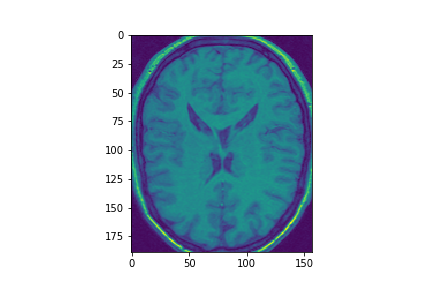

In [102]:
multi_slice_viewer(struct_arr2)

This works! Nice! But, if you try this out at home, you'll notice that scrolling up with K also squishes the horizontal scale of the plot. Huh?

<IPython.core.display.Javascript object>


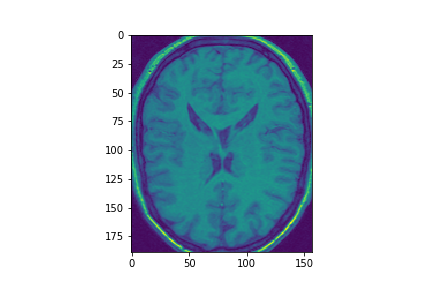

In [103]:
multi_slice_viewer(struct_arr2)

What's happening is that adding event handlers to Matplotlib simply piles them on on top of each other. In this case, K is a built-in keyboard shortcut to change the x-axis to use a logarithmic scale. If we want to use K exclusively, we have to remove it from matplotlib's default key maps. These live as lists in the `plt.rcParams` dictionary, which is matplotlib's repository for default system-wide settings:

    plt.rcParams['keymap.<command>'] = ['<key1>', '<key2>']

where pressing any of the keys in the list (i.e. `<key1>` or `<key2>`) will cause `<command>` to be executed.

Thus, we'll need to write a helper function to remove keys that we want to use wherever they may appear in this dictionary. (This function doesn't yet exist in matplotlib, but would probably be a welcome contribution!)

In [104]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

## A fully functional slice viewer

Ok, let's rewrite our function to make use of this new tool:

In [105]:
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

Now, we should be able to view all the slices in our MRI volume without pesky interference from the default keymap!

<IPython.core.display.Javascript object>


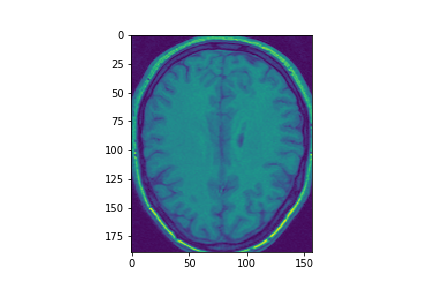

In [106]:
multi_slice_viewer(struct_arr2)

One nice feature about this method is that it works on *any* matplotlib backend! So, if you try this out in the IPython terminal console, you will still get the same interaction as you did in the browser! And the same is true for a Qt or Tkinter app embedding a matplotlib plot. This simple tool therefore lets you build ever more complex applications around matplotlib's visualisation capabilities.

## Before you go...

Let's not forget to clean up after ourselves, and delete the temporary directory (if you made one):

In [107]:
import shutil

# Remove the temporary directory
shutil.rmtree(d)

## Conclusion

Congrats! It has been quite a journey, but you have made it to the end of this Matplotlib tutorial!

Make sure to stay tuned for the second post of this series, in which you'll learn more on scaling subplots, crosshairs that show where each plot is sliced, and mouse interactivity. 

*If you want to know more about data visualization in Python, consider taking DataCamp's [Introduction to Data Visualization in Python](https://www.datacamp.com/courses/introduction-to-data-visualization-with-python) course.*